In [3]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import time

/Users/lokebankai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install lightgbm

     |████████████████████████████████| 1.9 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 17.7 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
tensorflow 2.16.2 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 1.22.4 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Glass Box - Decision Trees, Logistic Regression, Linear Regression

Black Box - LightGBM

In [4]:
!pip install lightgbm

In [5]:
# Load the dataset
file_path = '/Users/abhi/Downloads/randomairline2.csv'
data = pd.read_csv(file_path).drop('Unnamed: 0', axis=1)
data.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/abhi/Downloads/randomairline2.csv'

In [ ]:
file_path = '/Users/abhi/Downloads/randomairline2.csv'
data_test = pd.read_csv(file_path).drop('Unnamed: 0', axis=1)
data_test.shape

In [ ]:
data_test.isna().sum()

In [ ]:
data.isna().sum()

In [ ]:
# Impute missing values in 'Arrival Delay in Minutes' with the mean
data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].mean(), inplace=True)

In [ ]:
# Impute missing values in 'Arrival Delay in Minutes' with the mean
data_test['Arrival Delay in Minutes'].fillna(data_test['Arrival Delay in Minutes'].mean(), inplace=True)

In [ ]:
data.head(2)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encoding for binary categorical columns (Gender, satisfaction)
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['satisfaction'] = label_encoder.fit_transform(data['satisfaction'])  # Target variable

# One-hot encoding for multi-class categorical columns
data = pd.get_dummies(data, columns=['Customer Type', 'Type of Travel', 'Class'], drop_first=True)

# no scaling needed for lightGBM (itll handle it itself)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encoding for binary categorical columns (Gender, satisfaction)
label_encoder = LabelEncoder()
data_test['Gender'] = label_encoder.fit_transform(data_test['Gender'])
data_test['satisfaction'] = label_encoder.fit_transform(data_test['satisfaction'])  # Target variable

# One-hot encoding for multi-class categorical columns
data_test = pd.get_dummies(data_test, columns=['Customer Type', 'Type of Travel', 'Class'], drop_first=True)

# no scaling needed for lightGBM (itll handle it itself)


In [ ]:
data.head()

#### Train Test Split on train dataset

In [ ]:
X = data.drop(columns=['id', 'satisfaction'])  # Dropping 'id' as it's not useful for prediction
y = data['satisfaction']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# SAMPLING

Sampling is a technique used in data analysis and machine learning to reduce the size of the dataset or adjust the distribution of data points in a way that can lead to better model performance.

Types of Sampling:
1. Random - If the sample is too small or not representative, it can lead to biased or inaccurate models.

2. Stratified - Ensures that the sample has the same distribution of classes as the full dataset (used primarily in classification problems) - Doesn't address other types of imbalances, like feature imbalances.

3. Over Sampling - Risk of overfitting since duplicated samples might not add new information.

4. Under Sampling - Risk of losing important information by discarding samples from the majority class.

5. SMOTE - May introduce noise if synthetic samples do not represent realistic data

For our classification model - SMOTE is the best option

In [ ]:
## Check Class Imbalance


# Assuming 'y' is your target variable (customer satisfaction)
print(y.value_counts())

import matplotlib.pyplot as plt

# Plot the distribution of the target variable
y.value_counts().plot(kind='bar')
plt.title('Customer Satisfaction Distribution')
plt.xlabel('Satisfaction')
plt.ylabel('Count')
plt.show()


In [ ]:
# code for orig-sampled data comparison

def dist_com(y_train, y_sampled):

    # Plot original class distribution
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    y_train.value_counts().plot(kind='bar', title='Original Class Distribution')
    plt.ylabel('Count')

    # Plot sampled class distribution
    plt.subplot(1, 2, 2)
    y_sampled.value_counts().plot(kind='bar', title='Sampled Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [ ]:
## Random

# Random sampling (e.g., 20% of the data)
sampled_data = X_train.sample(frac=0.2, random_state=42)
sampled_labels = y_train.loc[sampled_data.index]

In [ ]:
# Comparison

dist_com(y_train, sampled_labels)

In [ ]:
## Stratified Sampling

from sklearn.model_selection import train_test_split

# Stratified sampling (e.g., 20% of the data)
X_sampled, _, y_sampled, _ = train_test_split(
    X_train, y_train, test_size=0.8, stratify=y_train, random_state=42
)

In [ ]:
# Comparison

dist_com(y_train, y_sampled)

In [ ]:
## Downsampling

from sklearn.utils import resample

# Combine features and labels
data_combined = pd.concat([X_train, y_train], axis=1)

# Replace 'target' with the actual name of the target column (e.g., 'satisfaction_satisfied')
target_column = 'satisfaction'  # Update this to the correct name

# Separate majority and minority classes
majority_class = data_combined[data_combined[target_column] == 0]
minority_class = data_combined[data_combined[target_column] == 1]

# Downsample majority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # Sample without replacement
    n_samples=len(minority_class),  # Match minority class count
    random_state=42
)

# Combine minority class with downsampled majority class
balanced_data = pd.concat([minority_class, majority_downsampled])
X_sampled = balanced_data.drop(target_column, axis=1)
y_sampled = balanced_data[target_column]

# Verify the sampling results
#print("Balanced data class distribution:")
print(balanced_data[target_column].value_counts())

Columns in data_combined: Index(['Gender', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel',
       'Class_Eco', 'Class_Eco Plus', 'satisfaction'],
      dtype='object')
Balanced data class distribution:
1    35957
0    35957
Name: satisfaction, dtype: int64


In [ ]:
# Comparison

dist_com(y_train, y_sampled)

In [ ]:
## Upsampling

from sklearn.utils import resample

# Combine majority and minority classes
balanced_data = pd.concat([majority_class, minority_upsampled])

# Replace 'target' with the actual target column name
target_column = 'satisfaction'  # Update this with the actual name

X_sampled = balanced_data.drop(target_column, axis=1)
y_sampled = balanced_data[target_column]

# Verify the results
print("Sampled Features Shape:", X_sampled.shape)
print("Sampled Target Distribution:")
print(y_sampled.value_counts())

Sampled Features Shape: (94332, 23)
Sampled Target Distribution:
0    47166
1    47166
Name: satisfaction, dtype: int64


In [ ]:
# Comparison

dist_com(y_train, y_sampled)

In [ ]:
## SMOTE

from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances all classes to the same size
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Original class distribution in training data:")
print(y_train.value_counts())
print("\nResampled class distribution in training data:")
print(pd.Series(y_resampled).value_counts())

In [ ]:
# Comparison

dist_com(y_train, y_resampled)

Which sampling tech to pick? SMOTE?

-> compare model performance before and after balancing data

## Feature importance in Sampled Data

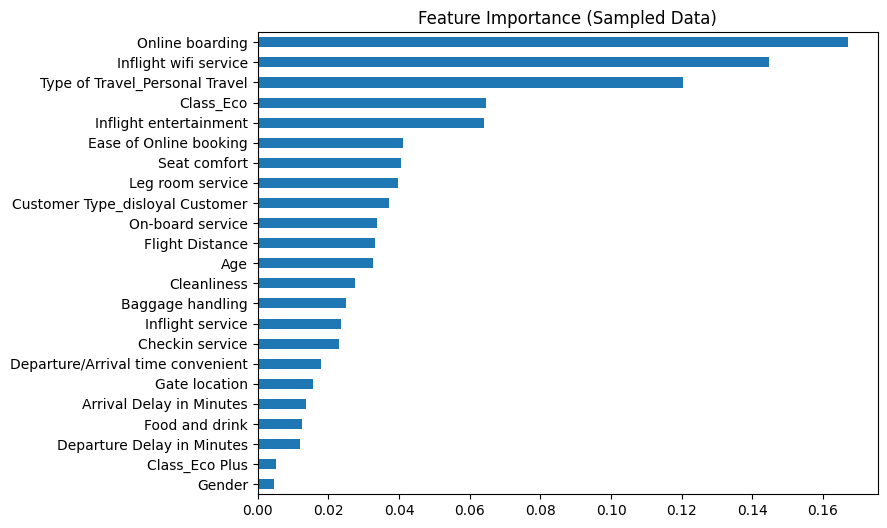

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit Random Forest on sampled data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_sampled, y_sampled)

# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=X_sampled.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance (Sampled Data)', figsize=(8, 6))
plt.show()

## Prototype (i.e. Cluster Based Sampling) (seems weird)

In [ ]:
# Check and print basic information about X_sampled
if isinstance(X_sampled, pd.DataFrame):
    print("Before Preprocessing:")
    print(X_sampled.info())
else:
    print("X_sampled is not a DataFrame. Shape:", X_sampled.shape)

# Handle non-numeric columns (if any)
if not isinstance(X_sampled, np.ndarray):
    if not all(X_sampled.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        X_sampled = pd.get_dummies(X_sampled, drop_first=True)

# Handle missing values (if any)
if not isinstance(X_sampled, np.ndarray):  # If still a DataFrame
    if X_sampled.isnull().sum().sum() > 0:
        print("Filling missing values in X_sampled.")
        X_sampled = X_sampled.fillna(X_sampled.mean())
elif np.isnan(X_sampled).any():  # If it's a NumPy array
    X_sampled = np.nan_to_num(X_sampled, nan=np.nanmean(X_sampled))

# Convert to NumPy array if needed
if isinstance(X_sampled, pd.DataFrame):
    X_sampled_np = X_sampled.to_numpy()
else:
    X_sampled_np = X_sampled

X_sampled is not a DataFrame. Shape: (94332, 23)


## Density Based Sampling

In [ ]:
import pandas as pd
import numpy as np

def preprocess_data(data):
    """Preprocess data to make it compatible with NearestNeighbors."""
    if isinstance(data, pd.DataFrame):
        # Handle categorical columns
        data = pd.get_dummies(data, drop_first=True)
        # Convert to numeric and fill missing values
        data = data.apply(pd.to_numeric, errors='coerce').fillna(data.mean())
        # Remove constant columns
        data = data.loc[:, data.std() > 0]
        return data.to_numpy()
    elif isinstance(data, np.ndarray):
        # Handle missing values and constant columns in NumPy array
        data = np.nan_to_num(data)
        data = data[:, np.std(data, axis=0) > 0]
        return data
    else:
        raise ValueError("Input data must be a DataFrame or NumPy array.")

# Apply preprocessing to X_sampled
X_sampled_processed = preprocess_data(X_sampled)
print("Preprocessed X_sampled Shape:", X_sampled_processed.shape)

Preprocessed X_sampled Shape: (94332, 23)


In [ ]:
# Validate processed data
if X_sampled_processed.shape[0] == 0 or X_sampled_processed.shape[1] == 0:
    raise ValueError("Processed X_sampled has no usable data. Check preprocessing steps.")

# Check for NaNs
if np.isnan(X_sampled_processed).any():
    raise ValueError("NaN values still exist in X_sampled after preprocessing.")

In [ ]:
from sklearn.neighbors import NearestNeighbors

try:
    # Apply NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=10, algorithm="auto")
    neighbors.fit(X_sampled_processed)
    distances, _ = neighbors.kneighbors(X_sampled_processed)

    # Sort by density (smaller distances = higher density)
    density_sorted_indices = np.argsort(distances.mean(axis=1))
    dense_sample = X_sampled_processed[density_sorted_indices[:len(X_sampled_processed) // 2]]

    print("Dense Sample Shape:", dense_sample.shape)

except Exception as e:
    print(f"Error during NearestNeighbors execution: {e}")

Error during NearestNeighbors execution: 'NoneType' object has no attribute 'split'


## Never Mind

In [ ]:
# Assign weights inversely proportional to class frequency
weights = 1 / y_train.value_counts(normalize=True).reindex(y_train).values
weighted_sample = X_train.sample(frac=0.2, weights=weights, random_state=42)

# Modelling Without Balancing of Data

## LightGBM

#### Train Test Split on train dataset

In [ ]:
X = data.drop(columns=['id', 'satisfaction'])  # Dropping 'id' as it's not useful for prediction
y = data['satisfaction']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# lightgbm does feature selection during training

In [14]:
#!pip install lightgbm

In [14]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize LightGBM model
model = lgb.LGBMClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 35957, number of negative: 47166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432576 -> initscore=-0.271350
[LightGBM] [Info] Start training from score -0.271350


LGBMClassifier(random_state=42)

In [15]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [16]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get a more detailed performance report
print(classification_report(y_test, y_pred))


Accuracy: 0.9631
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11713
           1       0.97      0.94      0.96      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781



#### Hyperparameter Tuning

Three Ways:
1. GridSearch - not good for huge dataset so skip it
2. Random Search - will do
3. Bayesian Optimisation with Optuna - will do

can compare 2 and 3 and then select which is better

In [17]:
## Random Search

from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import numpy as np

# Define the hyperparameter distributions
param_dist = {
    'num_leaves': np.arange(20, 100, 10),
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10]
}

# Initialize the model
model = LGBMClassifier(random_state=42)


# Start Timer
start_time = time.time()


# Perform Random Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

# End Timer
end_time = time.time()

# Random Search results
random_search_results = {
    'Method': 'Random Search',
    'Best Parameters': random_search.best_params_,
    'Best Score (CV)': random_search.best_score_,
    'Training Time (seconds)': end_time - start_time
}


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432569 -

In [19]:
#!pip install optuna

In [19]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
## Optuna

import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

# Define an objective function to optimize
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }
    
    model = LGBMClassifier(**param, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Start Timer
start_time = time.time()


# Create the study and optimize it
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# End Timer
end_time = time.time()


# Optuna results
optuna_results = {
    'Method': 'Optuna',
    'Best Parameters': study.best_params,
    'Best Score (CV)': study.best_value,
    'Training Time (seconds)': end_time - start_time
}


[I 2024-11-22 21:14:51,299] A new study created in memory with name: no-name-e498d034-bf77-4b35-b43a-cd186706c907


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-11-22 21:14:53,179] Trial 0 finished with value: 0.920816181695818 and parameters: {'num_leaves': 30, 'learning_rate': 0.013094002598232686, 'n_estimators': 110, 'max_depth': 5}. Best is trial 0 with value: 0.920816181695818.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-22 21:14:56,831] Trial 1 finished with value: 0.9633555414040395 and parameters: {'num_leaves': 97, 'learning_rate': 0.1560272914835487, 'n_estimators': 128, 'max_depth': 9}. Best is trial 1 with value: 0.9633555414040395.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:15:05,030] Trial 2 finished with value: 0.9628021282754528 and parameters: {'num_leaves': 57, 'learning_rate': 0.14454006933363212, 'n_estimators': 480, 'max_depth': 8}. Best is trial 1 with value: 0.9633555414040395.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:15:09,401] Trial 3 finished with value: 0.9481732109388004 and parameters: {'num_leaves': 51, 'learning_rate': 0.015376940543265716, 'n_estimators': 345, 'max_depth': 5}. Best is trial 1 with value: 0.9633555414040395.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, 

[I 2024-11-22 21:15:19,112] Trial 4 finished with value: 0.9617434693567413 and parameters: {'num_leaves': 89, 'learning_rate': 0.15490356386419749, 'n_estimators': 460, 'max_depth': 7}. Best is trial 1 with value: 0.9633555414040395.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:15:26,691] Trial 5 finished with value: 0.961514889244285 and parameters: {'num_leaves': 43, 'learning_rate': 0.17556747070471115, 'n_estimators': 464, 'max_depth': 6}. Best is trial 1 with value: 0.9633555414040395.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:15:31,715] Trial 6 finished with value: 0.9638487701448039 and parameters: {'num_leaves': 73, 'learning_rate': 0.08773425270906587, 'n_estimators': 146, 'max_depth': 9}. Best is trial 6 with value: 0.9638487701448039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:15:38,079] Trial 7 finished with value: 0.9619720501928546 and parameters: {'num_leaves': 46, 'learning_rate': 0.028837850981590474, 'n_estimators': 318, 'max_depth': 8}. Best is trial 6 with value: 0.9638487701448039.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from scor

[I 2024-11-22 21:15:45,877] Trial 8 finished with value: 0.9626938633880178 and parameters: {'num_leaves': 99, 'learning_rate': 0.19839214074141995, 'n_estimators': 210, 'max_depth': 9}. Best is trial 6 with value: 0.9638487701448039.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:15:50,533] Trial 9 finished with value: 0.9613103729004899 and parameters: {'num_leaves': 56, 'learning_rate': 0.06316298930130243, 'n_estimators': 299, 'max_depth': 5}. Best is trial 6 with value: 0.9638487701448039.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-22 21:15:52,424] Trial 10 finished with value: 0.9512289470065924 and parameters: {'num_leaves': 75, 'learning_rate': 0.09920558418414922, 'n_estimators': 204, 'max_depth': 3}. Best is trial 6 with value: 0.9638487701448039.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-22 21:15:55,983] Trial 11 finished with value: 0.9637284636036675 and parameters: {'num_leaves': 76, 'learning_rate': 0.10955471635876218, 'n_estimators': 100, 'max_depth': 10}. Best is trial 6 with value: 0.9638487701448039.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:16:01,346] Trial 12 finished with value: 0.9640773640067446 and parameters: {'num_leaves': 73, 'learning_rate': 0.10476009394426701, 'n_estimators': 178, 'max_depth': 10}. Best is trial 12 with value: 0.9640773640067446.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:16:07,215] Trial 13 finished with value: 0.9641856202102949 and parameters: {'num_leaves': 72, 'learning_rate': 0.0927273112030417, 'n_estimators': 186, 'max_depth': 10}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:16:13,506] Trial 14 finished with value: 0.9640532980671119 and parameters: {'num_leaves': 68, 'learning_rate': 0.05840020977548678, 'n_estimators': 224, 'max_depth': 10}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:16:21,608] Trial 15 finished with value: 0.9630186848256349 and parameters: {'num_leaves': 85, 'learning_rate': 0.12432096347229195, 'n_estimators': 266, 'max_depth': 10}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace

[I 2024-11-22 21:16:26,136] Trial 16 finished with value: 0.9631028989702359 and parameters: {'num_leaves': 64, 'learning_rate': 0.07339634019057467, 'n_estimators': 174, 'max_depth': 8}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:16:29,270] Trial 17 finished with value: 0.9573163061648347 and parameters: {'num_leaves': 82, 'learning_rate': 0.12488348014265552, 'n_estimators': 380, 'max_depth': 3}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-22 21:16:33,325] Trial 18 finished with value: 0.9610697800806154 and parameters: {'num_leaves': 30, 'learning_rate': 0.04061427081300875, 'n_estimators': 251, 'max_depth': 7}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:16:39,461] Trial 19 finished with value: 0.9636803556050857 and parameters: {'num_leaves': 91, 'learning_rate': 0.0874811725711803, 'n_estimators': 175, 'max_depth': 10}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002831 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:16:41,852] Trial 20 finished with value: 0.9628863496566249 and parameters: {'num_leaves': 20, 'learning_rate': 0.1200064675431514, 'n_estimators': 159, 'max_depth': 9}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:16:47,904] Trial 21 finished with value: 0.9640893832270765 and parameters: {'num_leaves': 66, 'learning_rate': 0.06071678554965888, 'n_estimators': 224, 'max_depth': 10}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:16:55,076] Trial 22 finished with value: 0.9637886248344636 and parameters: {'num_leaves': 65, 'learning_rate': 0.04735558359682628, 'n_estimators': 252, 'max_depth': 10}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of neg

[I 2024-11-22 21:17:00,943] Trial 23 finished with value: 0.9633916272876609 and parameters: {'num_leaves': 80, 'learning_rate': 0.08612088011987935, 'n_estimators': 191, 'max_depth': 9}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:17:07,866] Trial 24 finished with value: 0.9630788330306036 and parameters: {'num_leaves': 70, 'learning_rate': 0.10651523118266541, 'n_estimators': 242, 'max_depth': 8}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:17:15,579] Trial 25 finished with value: 0.9637044229920326 and parameters: {'num_leaves': 62, 'learning_rate': 0.07279678534201274, 'n_estimators': 283, 'max_depth': 10}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:17:19,787] Trial 26 finished with value: 0.9637525324379285 and parameters: {'num_leaves': 79, 'learning_rate': 0.13537093991754498, 'n_estimators': 143, 'max_depth': 9}. Best is trial 13 with value: 0.9641856202102949.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:17:24,932] Trial 27 finished with value: 0.9642939002945283 and parameters: {'num_leaves': 53, 'learning_rate': 0.09610888158607257, 'n_estimators': 218, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:17:29,934] Trial 28 finished with value: 0.961743467909427 and parameters: {'num_leaves': 39, 'learning_rate': 0.04858783889635012, 'n_estimators': 224, 'max_depth': 7}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:17:33,719] Trial 29 finished with value: 0.9594577130989167 and parameters: {'num_leaves': 54, 'learning_rate': 0.07907246958989521, 'n_estimators': 335, 'max_depth': 4}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:17:42,651] Trial 30 finished with value: 0.9636081780485863 and parameters: {'num_leaves': 50, 'learning_rate': 0.061741446174224356, 'n_estimators': 390, 'max_depth': 8}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:17:48,047] Trial 31 finished with value: 0.9632352319682749 and parameters: {'num_leaves': 60, 'learning_rate': 0.09748352502099572, 'n_estimators': 185, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:17:52,701] Trial 32 finished with value: 0.963548012475848 and parameters: {'num_leaves': 69, 'learning_rate': 0.11477006918493307, 'n_estimators': 124, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:18:00,128] Trial 33 finished with value: 0.9635600512349208 and parameters: {'num_leaves': 60, 'learning_rate': 0.10207638912692417, 'n_estimators': 221, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:18:05,714] Trial 34 finished with value: 0.963596144355113 and parameters: {'num_leaves': 72, 'learning_rate': 0.0915657300875401, 'n_estimators': 160, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:18:08,795] Trial 35 finished with value: 0.9629224492897306 and parameters: {'num_leaves': 38, 'learning_rate': 0.1362692672311477, 'n_estimators': 119, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:18:16,039] Trial 36 finished with value: 0.957460664896119 and parameters: {'num_leaves': 91, 'learning_rate': 0.02895399739665637, 'n_estimators': 271, 'max_depth': 6}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-22 21:18:21,838] Trial 37 finished with value: 0.9636562932837387 and parameters: {'num_leaves': 50, 'learning_rate': 0.07770172935756818, 'n_estimators': 198, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:18:30,658] Trial 38 finished with value: 0.9622848379369984 and parameters: {'num_leaves': 86, 'learning_rate': 0.15816212283666903, 'n_estimators': 237, 'max_depth': 8}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:18:35,468] Trial 39 finished with value: 0.9631750786977067 and parameters: {'num_leaves': 66, 'learning_rate': 0.13504449039609906, 'n_estimators': 144, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:18:40,799] Trial 40 finished with value: 0.9638006635935362 and parameters: {'num_leaves': 55, 'learning_rate': 0.0636005633647076, 'n_estimators': 166, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:18:48,803] Trial 41 finished with value: 0.9640532893832271 and parameters: {'num_leaves': 67, 'learning_rate': 0.05468487981176764, 'n_estimators': 218, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:18:58,587] Trial 42 finished with value: 0.9570396071989405 and parameters: {'num_leaves': 76, 'learning_rate': 0.01070720956814459, 'n_estimators': 232, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:19:08,820] Trial 43 finished with value: 0.9633675714792276 and parameters: {'num_leaves': 71, 'learning_rate': 0.030732001325380773, 'n_estimators': 296, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:19:14,109] Trial 44 finished with value: 0.9635119280395406 and parameters: {'num_leaves': 46, 'learning_rate': 0.06825964390167971, 'n_estimators': 203, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:19:21,424] Trial 45 finished with value: 0.9632953729366728 and parameters: {'num_leaves': 58, 'learning_rate': 0.09509137393555912, 'n_estimators': 264, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:19:26,551] Trial 46 finished with value: 0.9636081751539581 and parameters: {'num_leaves': 77, 'learning_rate': 0.08291465583961247, 'n_estimators': 138, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:19:33,933] Trial 47 finished with value: 0.9635720784154804 and parameters: {'num_leaves': 74, 'learning_rate': 0.03870864288949294, 'n_estimators': 187, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:19:39,467] Trial 48 finished with value: 0.9630547866297119 and parameters: {'num_leaves': 83, 'learning_rate': 0.11086553047109861, 'n_estimators': 206, 'max_depth': 6}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003369 seco

[I 2024-11-22 21:19:49,083] Trial 49 finished with value: 0.9610938322707636 and parameters: {'num_leaves': 64, 'learning_rate': 0.021597762631072603, 'n_estimators': 316, 'max_depth': 8}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:19:54,641] Trial 50 finished with value: 0.9599268824129622 and parameters: {'num_leaves': 96, 'learning_rate': 0.061609615978523824, 'n_estimators': 495, 'max_depth': 4}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:20:01,961] Trial 51 finished with value: 0.9638247179546557 and parameters: {'num_leaves': 68, 'learning_rate': 0.053263647165229376, 'n_estimators': 213, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:20:09,686] Trial 52 finished with value: 0.9640532908305411 and parameters: {'num_leaves': 68, 'learning_rate': 0.05872689325527135, 'n_estimators': 221, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:20:15,615] Trial 53 finished with value: 0.9628622895062489 and parameters: {'num_leaves': 62, 'learning_rate': 0.03916217839263132, 'n_estimators': 179, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace

[I 2024-11-22 21:20:23,247] Trial 54 finished with value: 0.9624291821951413 and parameters: {'num_leaves': 71, 'learning_rate': 0.19668725714405788, 'n_estimators': 251, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004460 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:20:30,330] Trial 55 finished with value: 0.96398111616867 and parameters: {'num_leaves': 57, 'learning_rate': 0.07095960943821683, 'n_estimators': 227, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:20:36,944] Trial 56 finished with value: 0.963560053405892 and parameters: {'num_leaves': 78, 'learning_rate': 0.08958613880035997, 'n_estimators': 159, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of neg

[I 2024-11-22 21:20:47,124] Trial 57 finished with value: 0.9630186804836924 and parameters: {'num_leaves': 74, 'learning_rate': 0.11695647139344241, 'n_estimators': 284, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:21:00,169] Trial 58 finished with value: 0.964005177042703 and parameters: {'num_leaves': 62, 'learning_rate': 0.055581273025860294, 'n_estimators': 433, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:21:05,879] Trial 59 finished with value: 0.9638608175877614 and parameters: {'num_leaves': 53, 'learning_rate': 0.07915158687926899, 'n_estimators': 194, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:21:14,398] Trial 60 finished with value: 0.9642337593261304 and parameters: {'num_leaves': 68, 'learning_rate': 0.04650729966464517, 'n_estimators': 242, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:21:23,524] Trial 61 finished with value: 0.9642337513659027 and parameters: {'num_leaves': 68, 'learning_rate': 0.04586959081380781, 'n_estimators': 251, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:21:31,857] Trial 62 finished with value: 0.9640773473626318 and parameters: {'num_leaves': 64, 'learning_rate': 0.041711653106616786, 'n_estimators': 254, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info]

[I 2024-11-22 21:21:41,114] Trial 63 finished with value: 0.9638367494771577 and parameters: {'num_leaves': 63, 'learning_rate': 0.04716176941144613, 'n_estimators': 252, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:21:49,854] Trial 64 finished with value: 0.9617675295071171 and parameters: {'num_leaves': 58, 'learning_rate': 0.02248476934666077, 'n_estimators': 271, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:22:00,728] Trial 65 finished with value: 0.9641856209339519 and parameters: {'num_leaves': 73, 'learning_rate': 0.03601733988780216, 'n_estimators': 285, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace

[I 2024-11-22 21:22:12,056] Trial 66 finished with value: 0.9634277095529971 and parameters: {'num_leaves': 73, 'learning_rate': 0.034356792313616075, 'n_estimators': 318, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:22:22,993] Trial 67 finished with value: 0.9635239769298124 and parameters: {'num_leaves': 81, 'learning_rate': 0.10323387614219645, 'n_estimators': 289, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:22:34,728] Trial 68 finished with value: 0.9627660474574309 and parameters: {'num_leaves': 70, 'learning_rate': 0.021241280956322474, 'n_estimators': 309, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:22:41,296] Trial 69 finished with value: 0.9632833500980554 and parameters: {'num_leaves': 47, 'learning_rate': 0.046524861839597934, 'n_estimators': 238, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:22:55,164] Trial 70 finished with value: 0.9621164053058535 and parameters: {'num_leaves': 85, 'learning_rate': 0.015556018512889552, 'n_estimators': 340, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info]

[I 2024-11-22 21:23:04,748] Trial 71 finished with value: 0.964017208565205 and parameters: {'num_leaves': 66, 'learning_rate': 0.04141605239780277, 'n_estimators': 262, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003114 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:23:12,835] Trial 72 finished with value: 0.964125480689211 and parameters: {'num_leaves': 60, 'learning_rate': 0.0442207716840632, 'n_estimators': 241, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

[I 2024-11-22 21:23:18,854] Trial 73 finished with value: 0.9636442675504933 and parameters: {'num_leaves': 53, 'learning_rate': 0.12460230792655105, 'n_estimators': 210, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:23:28,300] Trial 74 finished with value: 0.963981106761128 and parameters: {'num_leaves': 60, 'learning_rate': 0.050949139085158884, 'n_estimators': 275, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:23:36,971] Trial 75 finished with value: 0.9638126871558106 and parameters: {'num_leaves': 75, 'learning_rate': 0.033519782858017266, 'n_estimators': 241, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:23:43,080] Trial 76 finished with value: 0.9633795986597871 and parameters: {'num_leaves': 66, 'learning_rate': 0.0655174047795699, 'n_estimators': 171, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of neg

[I 2024-11-22 21:23:48,996] Trial 77 finished with value: 0.9639690774095971 and parameters: {'num_leaves': 42, 'learning_rate': 0.10912121926850966, 'n_estimators': 232, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:23:56,540] Trial 78 finished with value: 0.9562215526786166 and parameters: {'num_leaves': 72, 'learning_rate': 0.02597941215008083, 'n_estimators': 197, 'max_depth': 7}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:24:07,695] Trial 79 finished with value: 0.963223202616744 and parameters: {'num_leaves': 70, 'learning_rate': 0.07505382339676027, 'n_estimators': 358, 'max_depth': 8}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:24:12,208] Trial 80 finished with value: 0.9620803136329756 and parameters: {'num_leaves': 79, 'learning_rate': 0.09538650439901035, 'n_estimators': 246, 'max_depth': 5}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:24:21,449] Trial 81 finished with value: 0.963740509599311 and parameters: {'num_leaves': 64, 'learning_rate': 0.04357782369710296, 'n_estimators': 260, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:24:30,014] Trial 82 finished with value: 0.9639811161686701 and parameters: {'num_leaves': 59, 'learning_rate': 0.08317593718624969, 'n_estimators': 280, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:24:39,145] Trial 83 finished with value: 0.9634638062914747 and parameters: {'num_leaves': 56, 'learning_rate': 0.036563945134351857, 'n_estimators': 257, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:24:48,873] Trial 84 finished with value: 0.9636562918364244 and parameters: {'num_leaves': 68, 'learning_rate': 0.05006253099406137, 'n_estimators': 297, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:24:55,346] Trial 85 finished with value: 0.9609133818666011 and parameters: {'num_leaves': 61, 'learning_rate': 0.029109073093408527, 'n_estimators': 183, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info]

[I 2024-11-22 21:25:04,150] Trial 86 finished with value: 0.9640412629263245 and parameters: {'num_leaves': 76, 'learning_rate': 0.04227220604305278, 'n_estimators': 214, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:25:11,538] Trial 87 finished with value: 0.9635239660749564 and parameters: {'num_leaves': 65, 'learning_rate': 0.13067691535952786, 'n_estimators': 228, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info]

[I 2024-11-22 21:25:18,605] Trial 88 finished with value: 0.9637284831424084 and parameters: {'num_leaves': 48, 'learning_rate': 0.10030537252743163, 'n_estimators': 243, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:25:26,040] Trial 89 finished with value: 0.9639209621744447 and parameters: {'num_leaves': 73, 'learning_rate': 0.05771816368238063, 'n_estimators': 203, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:25:30,276] Trial 90 finished with value: 0.9633194432182478 and parameters: {'num_leaves': 51, 'learning_rate': 0.15210244670319203, 'n_estimators': 152, 'max_depth': 9}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:25:38,590] Trial 91 finished with value: 0.9638367596083567 and parameters: {'num_leaves': 69, 'learning_rate': 0.04416796901183234, 'n_estimators': 220, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003129 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:25:46,514] Trial 92 finished with value: 0.9640292379167359 and parameters: {'num_leaves': 64, 'learning_rate': 0.06961164106202497, 'n_estimators': 234, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:25:54,501] Trial 93 finished with value: 0.9642698343548959 and parameters: {'num_leaves': 67, 'learning_rate': 0.060176381948847855, 'n_estimators': 250, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-11-22 21:25:58,206] Trial 94 finished with value: 0.9544410451055455 and parameters: {'num_leaves': 67, 'learning_rate': 0.05395970118954482, 'n_estimators': 267, 'max_depth': 4}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-22 21:26:06,476] Trial 95 finished with value: 0.9628983775608415 and parameters: {'num_leaves': 71, 'learning_rate': 0.09178764799964387, 'n_estimators': 248, 'max_depth': 10}. Best is trial 27 with value: 0.9642939002945283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:26:16,265] Trial 96 finished with value: 0.964618727521402 and parameters: {'num_leaves': 62, 'learning_rate': 0.06050646549213748, 'n_estimators': 287, 'max_depth': 10}. Best is trial 96 with value: 0.964618727521402.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:26:25,854] Trial 97 finished with value: 0.9640172034996055 and parameters: {'num_leaves': 62, 'learning_rate': 0.06510895279504497, 'n_estimators': 288, 'max_depth': 10}. Best is trial 96 with value: 0.964618727521402.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

[I 2024-11-22 21:26:35,289] Trial 98 finished with value: 0.964305925304117 and parameters: {'num_leaves': 55, 'learning_rate': 0.060127794225697584, 'n_estimators': 310, 'max_depth': 10}. Best is trial 96 with value: 0.964618727521402.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28766, number of negative: 37732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 66498, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432584 -> initscore=-0.271314
[LightGBM] [Info] Start training from score -0.271314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28765, number of negative: 37733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_row_wise=true`

[I 2024-11-22 21:26:44,653] Trial 99 finished with value: 0.9640893940819325 and parameters: {'num_leaves': 55, 'learning_rate': 0.060450551527244385, 'n_estimators': 302, 'max_depth': 10}. Best is trial 96 with value: 0.964618727521402.


In [21]:
# Create a comparison table
results_df = pd.DataFrame([random_search_results, optuna_results])

# Display the comparison table
print(results_df)

          Method                                    Best Parameters  \
0  Random Search  {'num_leaves': 70, 'n_estimators': 200, 'max_d...   
1         Optuna  {'num_leaves': 62, 'learning_rate': 0.06050646...   

   Best Score (CV)  Training Time (seconds)  
0         0.963608                63.402562  
1         0.964619               713.355372  


Performance: The Optuna method provides a slightly better cross-validation score (96.42% vs. 96.40% from Random Search), suggesting it finds slightly more optimal hyperparameters for the model.

Efficiency: Random Search is significantly faster (136.91 seconds vs. 1094.83 seconds). This makes it more efficient if you prioritize speed over a marginal increase in performance.


Optuna is my way to go for this as I prioritize performance for now

In [22]:
## Put optuna parameters in LighGBM

import time
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier

# Step 1: Train the model with the best parameters from Optuna
best_params = study.best_params
model_lgm = LGBMClassifier(**best_params, random_state=42)

# Train the model on the full training set
model_lgm.fit(X_train, y_train)

# Step 2: Make predictions on the test set
y_test_pred = model_lgm.predict(X_test)

# Step 3: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 4: Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Optionally, you can also calculate confusion matrix to see false positives/negatives
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 35957, number of negative: 47166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432576 -> initscore=-0.271350
[LightGBM] [Info] Start training from score -0.271350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Test Accuracy: 0.9639
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11713
           1       0.98      0.94      0.96      9068

    

### Decision Trees

In [23]:
# check for imbalance
print(y.value_counts())


0    58879
1    45025
Name: satisfaction, dtype: int64


Your satisfaction classes have a ratio of approximately 56:44, which is a slight imbalance but not severe. However, even small imbalances can impact performance, especially for decision trees.

In [24]:
# fix imbalance and fit model

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [25]:

from sklearn.metrics import classification_report, accuracy_score

# Train a basic Decision Tree model
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))


Accuracy: 0.9467301862278042
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     11713
           1       0.94      0.94      0.94      9068

    accuracy                           0.95     20781
   macro avg       0.95      0.95      0.95     20781
weighted avg       0.95      0.95      0.95     20781



Two ways for hyperparameter tuning:
1. gridsearch
2. random search - just do this

In [26]:
## Random Search

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter grid
param_grid = {
    'max_depth': np.arange(3, 20),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'criterion': ['gini', 'entropy']
}

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)


Best Parameters: {'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 17, 'criterion': 'entropy'}
Best CV Accuracy: 0.949352224160015


In [27]:
## Evaluate Tuned Model on Test Set

# Train the model with the best parameters
# the best model found during the cross-validation process is accessible via random_search.best_estimator_
model_tree = random_search.best_estimator_

# Predict on the test set
y_test_pred_tuned = model_tree.predict(X_test)

# Evaluate the tuned model
print("Tuned Model Accuracy:", accuracy_score(y_test, y_test_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_test_pred_tuned))


Tuned Model Accuracy: 0.9519753621096194
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     11713
           1       0.95      0.94      0.94      9068

    accuracy                           0.95     20781
   macro avg       0.95      0.95      0.95     20781
weighted avg       0.95      0.95      0.95     20781



### Loss Calculations

In [ ]:
# LightGBM Model - model_lgm
# Decision Tree Model - model_tree
# Test Data - data_test

# LightGBM - y_test, y_test_pred
# Decision Tree - y_test, y_test_pred_tuned

In [ ]:
# False Positive Loss (Cost of misclassifying an unsatisfied customer as satisfied): You might assign a higher penalty because keeping unsatisfied customers is critical for business.
# False Negative Loss (Cost of misclassifying a satisfied customer as unsatisfied): This could have a lower penalty in comparison.

In [ ]:
# Baseline Loss for both: standard loss function (e.g., binary cross-entropy) 
# Weighted loss: For a weighted loss, you'll assign different penalties to false positives (FP) and false negatives (FN) and compute the weighted log loss manually.

In [28]:
# Baseline

from sklearn.metrics import log_loss

# Predictions (probabilities) from your models
y_pred_tree = model_tree.predict_proba(X_test)[:, 1]
y_pred_lgbm = model_lgm.predict_proba(X_test)[:, 1]

# Compute baseline loss (log loss)
baseline_loss_tree = log_loss(y_test, y_pred_tree)
baseline_loss_lgbm = log_loss(y_test, y_pred_lgbm)

print(f"Baseline Loss - Decision Tree: {baseline_loss_tree}")
print(f"Baseline Loss - LightGBM: {baseline_loss_lgbm}")


Baseline Loss - Decision Tree: 0.6653850659421839
Baseline Loss - LightGBM: 0.08431373167825106


In [30]:
# Hinge Loss

from sklearn.metrics import hinge_loss

# Convert probabilities to binary predictions for hinge loss
y_pred_binary_tree = (y_test_pred_tuned >= 0.5).astype(int)
y_pred_binary_lgbm = (y_test_pred >= 0.5).astype(int)

# Compute hinge loss
hinge_loss_tree = hinge_loss(y_test, y_test_pred_tuned)
hinge_loss_lgbm = hinge_loss(y_test, y_test_pred)

print(f"Hinge Loss - Decision Tree: {hinge_loss_tree}")
print(f"Hinge Loss - LightGBM: {hinge_loss_lgbm}")


Hinge Loss - Decision Tree: 0.6116645012270824
Hinge Loss - LightGBM: 0.6169096771088975


In [31]:
# Misclassification rate measures the fraction of incorrect predictions.

from sklearn.metrics import accuracy_score

# Convert probabilities to binary predictions
y_pred_binary_tree = (y_test_pred_tuned >= 0.5).astype(int)
y_pred_binary_lgbm = (y_test_pred >= 0.5).astype(int)

# Misclassification rate
misclassification_tree = 1 - accuracy_score(y_test, y_test_pred_tuned)
misclassification_lgbm = 1 - accuracy_score(y_test, y_test_pred)

print(f"Misclassification Rate - Decision Tree: {misclassification_tree}")
print(f"Misclassification Rate - LightGBM: {misclassification_lgbm}")


Misclassification Rate - Decision Tree: 0.048024637890380584
Misclassification Rate - LightGBM: 0.05326981377219575


In [32]:
# MAE

from sklearn.metrics import mean_absolute_error

mae_tree = mean_absolute_error(y_test, y_test_pred_tuned)
mae_lgbm = mean_absolute_error(y_test, y_test_pred)

print(f"Mean Absolute Error (MAE) - Decision Tree: {mae_tree}")
print(f"Mean Absolute Error (MAE) - LightGBM: {mae_lgbm}")


Mean Absolute Error (MAE) - Decision Tree: 0.04802463789038064
Mean Absolute Error (MAE) - LightGBM: 0.05326981377219576


In [33]:
# MSE and RMSE

from sklearn.metrics import mean_squared_error
import numpy as np

mse_tree = mean_squared_error(y_test, y_test_pred_tuned)
rmse_tree = np.sqrt(mse_tree)

mse_lgbm = mean_squared_error(y_test, y_test_pred)
rmse_lgbm = np.sqrt(mse_lgbm)

print(f"Mean Squared Error (MSE) - Decision Tree: {mse_tree}")
print(f"Root Mean Squared Error (RMSE) - Decision Tree: {rmse_tree}")

print(f"Mean Squared Error (MSE) - LightGBM: {mse_lgbm}")
print(f"Root Mean Squared Error (RMSE) - LightGBM: {rmse_lgbm}")


Mean Squared Error (MSE) - Decision Tree: 0.04802463789038064
Root Mean Squared Error (RMSE) - Decision Tree: 0.21914524382331604
Mean Squared Error (MSE) - LightGBM: 0.05326981377219576
Root Mean Squared Error (RMSE) - LightGBM: 0.23080254282003862


In [34]:
# Rsquare

from sklearn.metrics import r2_score

r2_tree = r2_score(y_test, y_test_pred_tuned)
r2_lgbm = r2_score(y_test, y_test_pred)

print(f"R² Score - Decision Tree: {r2_tree}")
print(f"R² Score - LightGBM: {r2_lgbm}")


R² Score - Decision Tree: 0.804738181830096
R² Score - LightGBM: 0.7834119912684532


In [35]:
# MAPE

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.clip(y_true, 1e-7, None)  # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_tree = mean_absolute_percentage_error(y_test, y_test_pred_tuned)
mape_lgbm = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Mean Absolute Percentage Error (MAPE) - Decision Tree: {mape_tree}%")
print(f"Mean Absolute Percentage Error (MAPE) - LightGBM: {mape_lgbm}%")


Mean Absolute Percentage Error (MAPE) - Decision Tree: 21798813.108127624%
Mean Absolute Percentage Error (MAPE) - LightGBM: 26755262.74962707%


In [36]:
# Consolidate Results

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Metrics for Decision Tree
accuracy_tree = accuracy_score(y_test, y_pred_binary_tree)
precision_tree = precision_score(y_test, y_pred_binary_tree)
recall_tree = recall_score(y_test, y_pred_binary_tree)
f1_tree = f1_score(y_test, y_pred_binary_tree)

# Metrics for LightGBM
accuracy_lgbm = accuracy_score(y_test, y_pred_binary_lgbm)
precision_lgbm = precision_score(y_test, y_pred_binary_lgbm)
recall_lgbm = recall_score(y_test, y_pred_binary_lgbm)
f1_lgbm = f1_score(y_test, y_pred_binary_lgbm)


# Loss values for Decision Tree
loss_tree = {
    "Baseline Log Loss": baseline_loss_tree,
    "Weighted Loss": weighted_loss_tree,
    "Misclassification Rate": misclassification_tree,
    "MAE": mae_tree,
    "MSE": mse_tree,
    "RMSE": rmse_tree,
    "R²": r2_tree,
    "MAPE (%)": mape_tree,
    "Accuracy": accuracy_tree,
    "Precision": precision_tree,
    "Recall": recall_tree,
    "F1 Score": f1_tree
}

# Loss values for LightGBM
loss_lgbm = {
    "Baseline Log Loss": baseline_loss_lgbm,
    "Weighted Loss": weighted_loss_lgbm,
    "Misclassification Rate": misclassification_lgbm,
    "MAE": mae_lgbm,
    "MSE": mse_lgbm,
    "RMSE": rmse_lgbm,
    "R²": r2_lgbm,
    "MAPE (%)": mape_lgbm,
    "Accuracy": accuracy_lgbm,
    "Precision": precision_lgbm,
    "Recall": recall_lgbm,
    "F1 Score": f1_lgbm
}

# Consolidate into a DataFrame
loss_df = pd.DataFrame([loss_tree, loss_lgbm], index=["Decision Tree", "LightGBM"])

# Display the DataFrame
print(loss_df)


               Baseline Log Loss  Weighted Loss  Misclassification Rate  \
Decision Tree           0.665385            inf                0.048025   
LightGBM                0.084314            inf                0.053270   

                    MAE       MSE      RMSE        R²      MAPE (%)  Accuracy  \
Decision Tree  0.048025  0.048025  0.219145  0.804738  2.179881e+07  0.951975   
LightGBM       0.053270  0.053270  0.230803  0.783412  2.675526e+07  0.946730   

               Precision    Recall  F1 Score  
Decision Tree   0.949532  0.939899  0.944691  
LightGBM        0.938719  0.939237  0.938978  


### Shap Ratio

SHAP (SHapley Additive exPlanations) ratio analysis is a method to understand how different features contribute to a model's predictions in relation to their importance scores.

SHAP Ratio for Feature = Mean Absolute SHAP of Feature / Sum of Mean Absolute SHAP of All Features
​	
 

In [28]:
# LightGBM Model - model_lgm
# Decision Tree Model - model_tree
# Test Data - data_test

In [29]:
!pip install --upgrade numpy pandas scikit-learn lightgbm


In [30]:
import shap

# Create SHAP explainer
# For tree-based models like Decision Tree and LightGBM, use TreeExplainer.
explainer_lgm = shap.TreeExplainer(model_lgm)
explainer_tree = shap.TreeExplainer(model_tree) 

In [31]:
# Use the explainer to calculate the SHAP values for your model's predictions.
shap_values_lgm = explainer_lgm.shap_values(X_train)
shap_values_tree = explainer_tree.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [34]:
# Show feature importance for the model (global explanation)
shap.summary_plot(shap_values_lgm, X_train)
shap.summary_plot(shap_values_tree, X_train)
# This will plot the SHAP values for each feature, showing both the magnitude and direction of their impact on predictions.

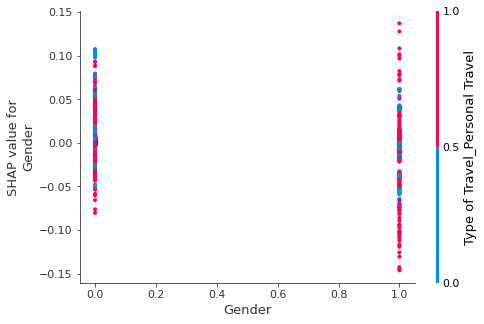

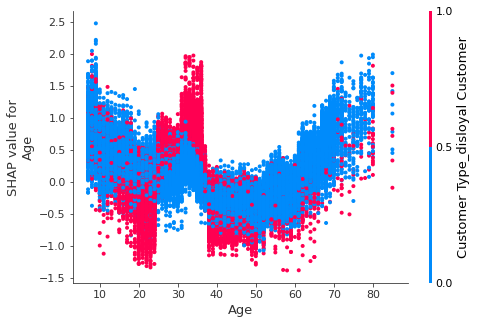

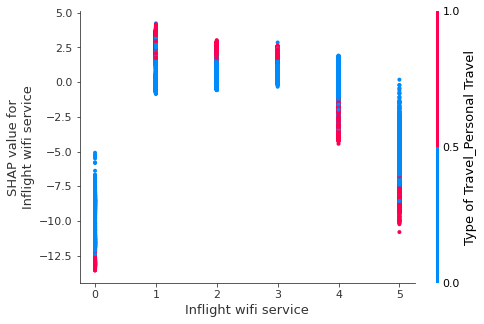

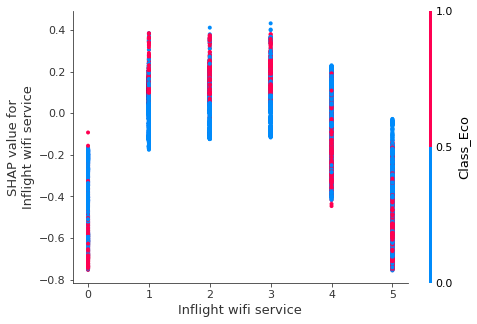

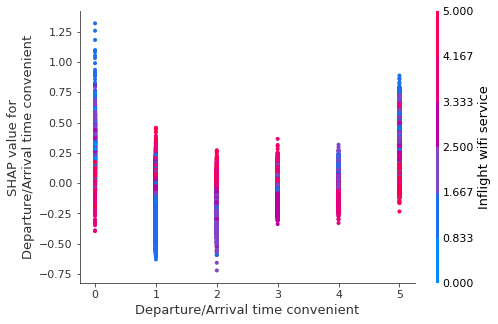

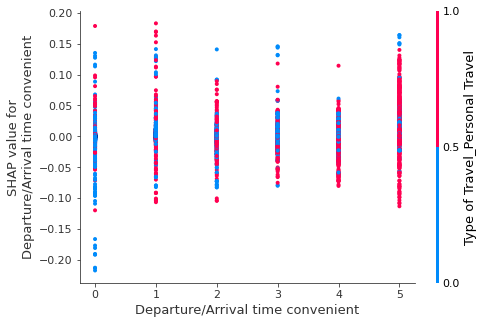

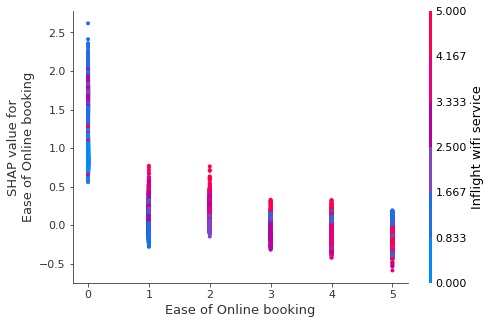

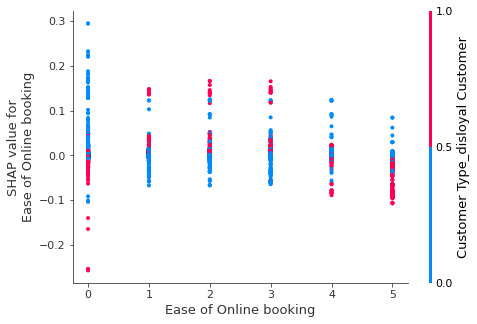

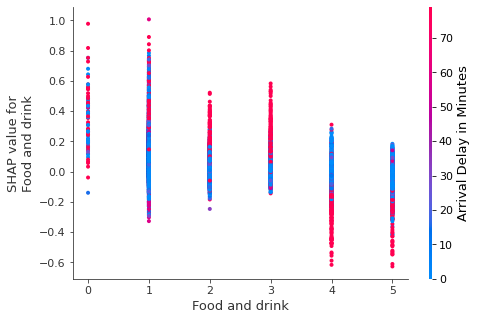

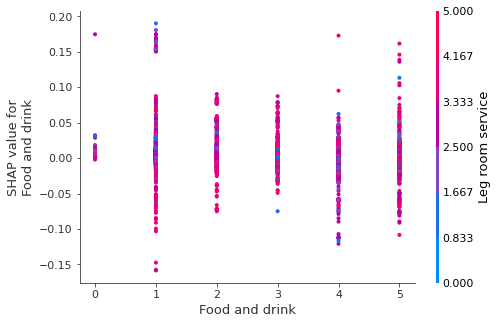

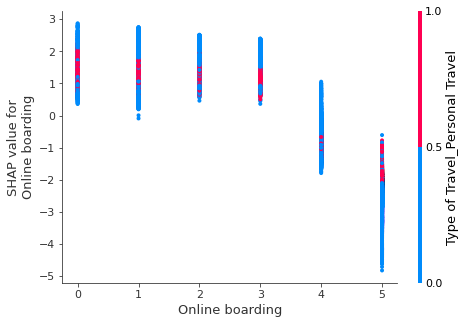

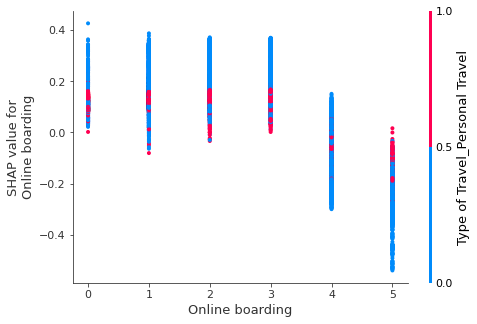

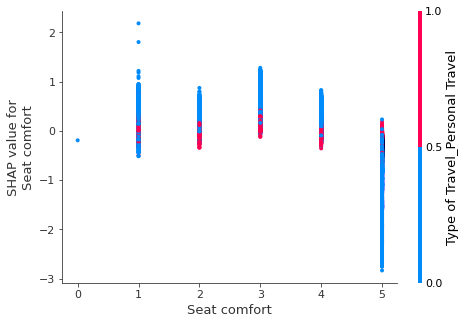

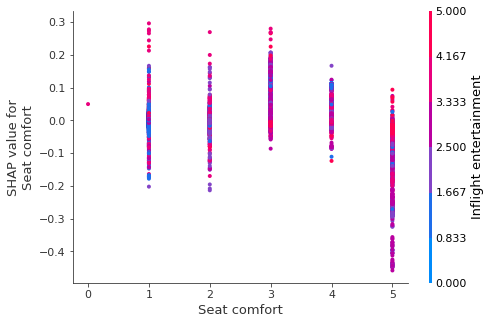

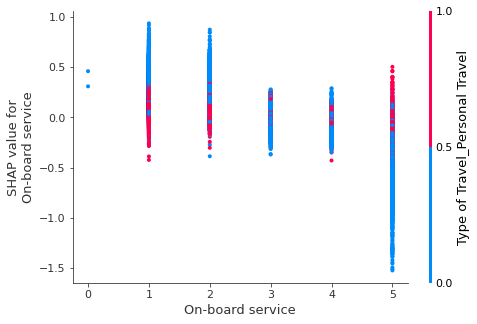

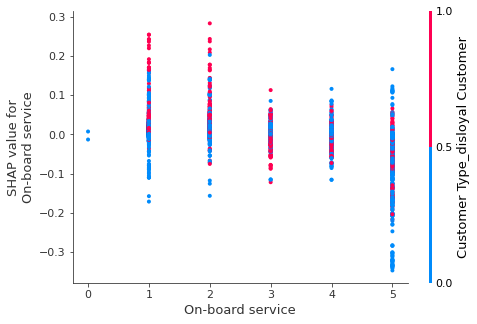

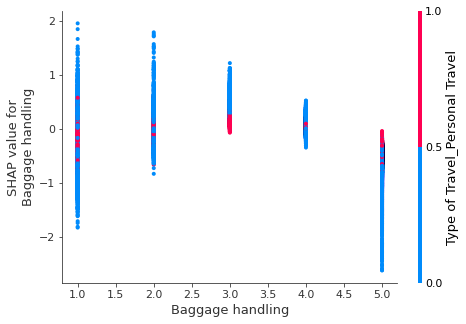

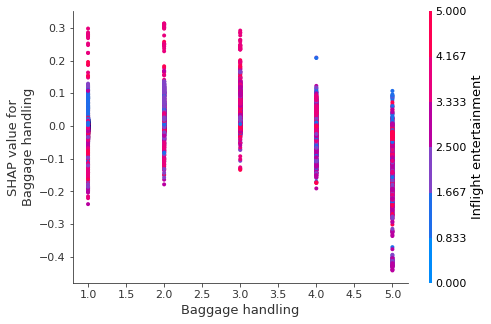

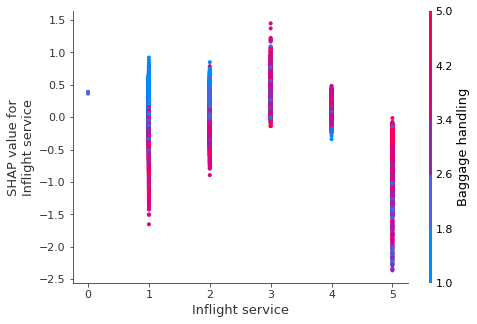

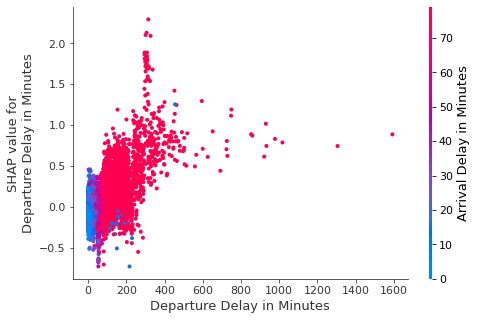

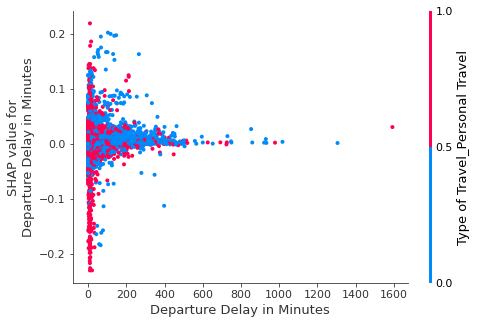

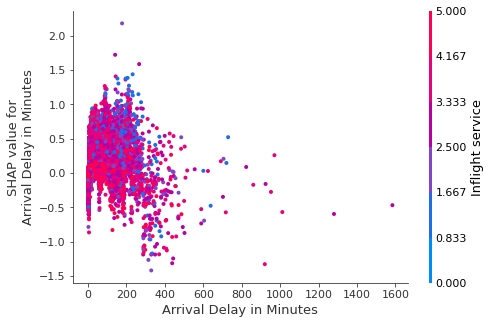

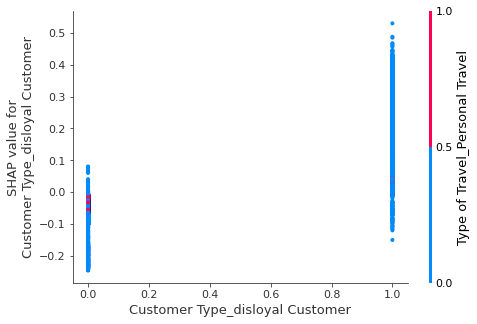

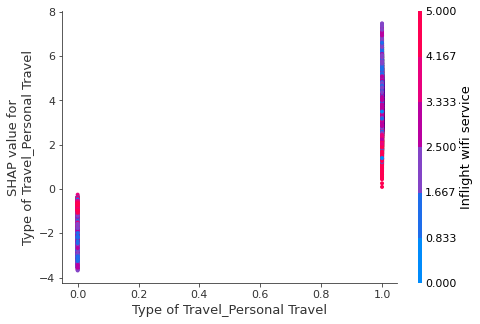

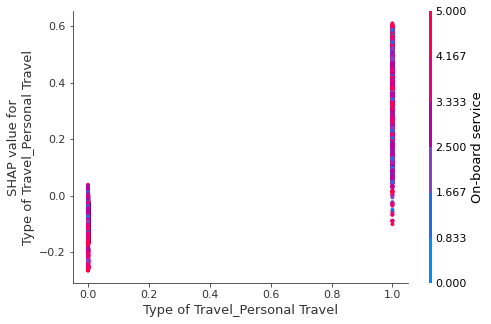

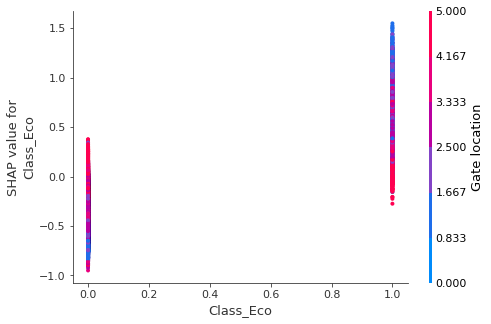

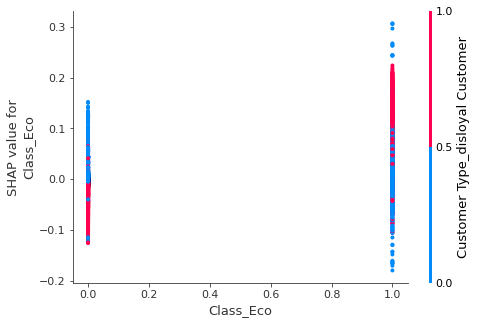

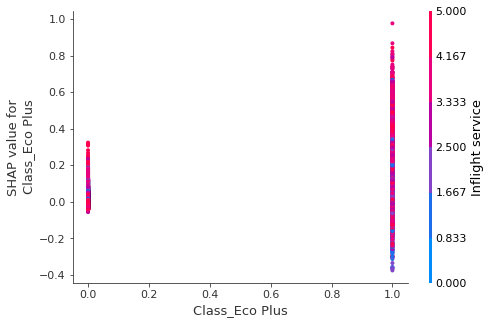

In [37]:
# Visualize how a feature affects the model's prediction, accounting for feature interactions.
# Loop through all feature names in X_train
for feature in X_train.columns:
    shap.dependence_plot(feature, shap_values_lgm[0], X_train)
    shap.dependence_plot(feature, shap_values_tree[0], X_train)



In [ ]:
# Explore interactions between features using SHAP interaction values.
shap_interaction_values_lgm = explainer_lgm.shap_interaction_values(X_train)
shap_interaction_values_tree = explainer_tree.shap_interaction_values(X_train)

By visualizing SHAP values, you can gain insights into which features are driving the predictions and how they influence the model’s output. This helps interpretability and model transparency, especially for black-box models like LightGBM.